In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

# Commonly used modules
import numpy as np
import os
import sys

# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import cv2
import IPython
from six.moves import urllib

## Convolutional Neural Networks

In [ ]:
(train_images, train_labels), (test_images, test_labels) = keras.datasets.mnist.load_data()

# reshape images to specify that it's a single channel
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
def preprocess_images(imgs): # should work for both a single image and multiple images
    sample_img = imgs if len(imgs.shape) == 2 else imgs[0]
    assert sample_img.shape in [(28, 28, 1), (28, 28)], sample_img.shape # make sure images are 28x28 and single-channel (grayscale)
    return imgs / 255.0

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

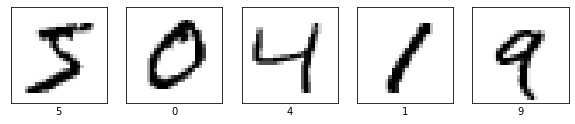

In [ ]:
plt.figure(figsize=(10,2))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i].reshape(28, 28), cmap=plt.cm.binary)
    plt.xlabel(train_labels[i])

### Build the model

In [ ]:
model = keras.Sequential()
# 32 convolution filters used each of size 3x3
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
# 64 convolution filters used each of size 3x3
model.add(Conv2D(64, (3, 3), activation='relu'))
# choose the best features via pooling
model.add(MaxPooling2D(pool_size=(2, 2)))
# randomly turn neurons on and off to improve convergence
model.add(Dropout(0.25))
# flatten since too many dimensions, we only want a classification output
model.add(Flatten())
# fully connected to get all relevant data
model.add(Dense(128, activation='relu'))
# one more dropout
model.add(Dropout(0.5))
# output a softmax to squash the matrix into output probabilities
model.add(Dense(10, activation='softmax'))

In [ ]:
model.compile(tf.optimizers.Adam(), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Train the model

In [ ]:
history = model.fit(train_images, train_labels, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 114s 61ms/step - loss: 0.1892 - accuracy: 0.9425
Epoch 2/5
1875/1875 [==============================] - 113s 60ms/step - loss: 0.0801 - accuracy: 0.9768
Epoch 3/5
1875/1875 [==============================] - 113s 60ms/step - loss: 0.0607 - accuracy: 0.9814
Epoch 4/5
1875/1875 [==============================] - 113s 60ms/step - loss: 0.0509 - accuracy: 0.9844
Epoch 5/5
1875/1875 [==============================] - 114s 61ms/step - loss: 0.0415 - accuracy: 0.9866


As the model trains, the loss and accuracy metrics are displayed. This model reaches an accuracy of about 98.6% on the training data.

### Evaluate accuracy

In [ ]:
print(test_images.shape)
test_loss, test_acc = model.evaluate(test_images, test_labels)

print('Test accuracy:', test_acc)

(10000, 28, 28, 1)
313/313 [==============================] - 5s 15ms/step - loss: 0.0322 - accuracy: 0.9903
Test accuracy: 0.9902999997138977


### Make predictions

![MNIST dream](https://i.imgur.com/OrUJs9V.gif)

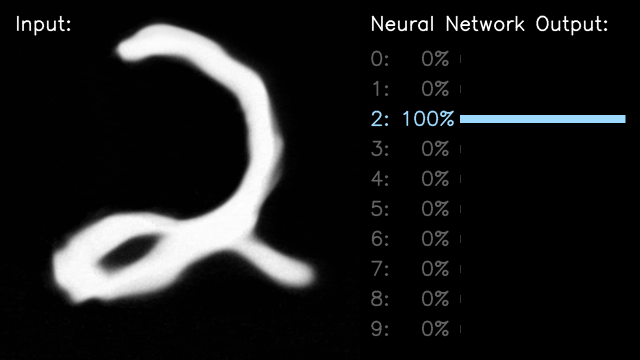

In [ ]:
mnist_dream_path = 'images/mnist_dream.mp4'
mnist_prediction_path = 'images/mnist_dream_predicted.mp4'

# download the video if running in Colab
if not os.path.isfile(mnist_dream_path): 
    print('downloading the sample video...')
    vid_url = 'https://i.imgur.com/OrUJs9V.gif'+ '/' + mnist_dream_path
    
    mnist_dream_path = urllib.request.urlretrieve(vid_url)[0]
                                                                                                  
def cv2_imshow(img):
    ret = cv2.imencode('.png', img)[1].tobytes() 
    img_ip = IPython.display.Image(data=ret)
    IPython.display.display(img_ip)

cap = cv2.VideoCapture(mnist_dream_path) 
vw = None
frame = -1 # counter for debugging (mostly), 0-indexed

# go through all the frames and run our classifier on the high res MNIST images as they morph from number to number
while True: # should 481 frames
    frame += 1
    ret, img = cap.read()
    if not ret: break
               
    assert img.shape[0] == img.shape[1] # should be a square
    if img.shape[0] != 720:
        img = cv2.resize(img, (720, 720))
       
    #preprocess the image for prediction
    img_proc = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_proc = cv2.resize(img_proc, (28, 28))
    img_proc = preprocess_images(img_proc)
    img_proc = 1 - img_proc # inverse since training dataset is white text with black background

    net_in = np.expand_dims(img_proc, axis=0) # expand dimension to specify batch size of 1
    net_in = np.expand_dims(net_in, axis=3) # expand dimension to specify number of channels
    
    preds = model.predict(net_in)[0]
    guess = np.argmax(preds)
    perc = np.rint(preds * 100).astype(int)
    
    img = 255 - img
    pad_color = 0
    img = np.pad(img, ((0,0), (0,1280-720), (0,0)), mode='constant', constant_values=(pad_color))  
    
    line_type = cv2.LINE_AA
    font_face = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1.3        
    thickness = 2
    x, y = 740, 60
    color = (255, 255, 255)
    
    text = "Neural Network Output:"
    cv2.putText(img, text=text, org=(x, y), fontScale=font_scale, fontFace=font_face, thickness=thickness,
                    color=color, lineType=line_type)
    
    text = "Input:"
    cv2.putText(img, text=text, org=(30, y), fontScale=font_scale, fontFace=font_face, thickness=thickness,
                    color=color, lineType=line_type)   
        
    y = 130
    for i, p in enumerate(perc):
        if i == guess: color = (255, 218, 158)
        else: color = (100, 100, 100)
            
        rect_width = 0
        if p > 0: rect_width = int(p * 3.3)
        
        rect_start = 180
        cv2.rectangle(img, (x+rect_start, y-5), (x+rect_start+rect_width, y-20), color, -1)

        text = '{}: {:>3}%'.format(i, int(p))
        cv2.putText(img, text=text, org=(x, y), fontScale=font_scale, fontFace=font_face, thickness=thickness,
                    color=color, lineType=line_type)
        y += 60
    
    # if you don't want to save the output as a video, set this to False
    save_video = True
    
    if save_video:
        if vw is None:
            codec = cv2.VideoWriter_fourcc(*'DIVX')
            vid_width_height = img.shape[1], img.shape[0]
            vw = cv2.VideoWriter(mnist_prediction_path, codec, 15, vid_width_height)
        # 15 fps above doesn't work robustly so we right frame twice at 30 fps
        vw.write(img)
        vw.write(img)
    
    # scale down image for display
    img_disp = cv2.resize(img, (0,0), fx=0.5, fy=0.5)
    cv2_imshow(img_disp)
    IPython.display.clear_output(wait=True)
        
cap.release()
if vw is not None:
    vw.release()